In [186]:
#importing packages 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import re
import nltk
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import contractions
import wordninja
from joblib import Parallel, delayed
import tqdm
from tqdm.notebook import tqdm
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim
from gensim.models import Phrases
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from textblob import TextBlob
from pprint import pprint

[nltk_data] Downloading package words to
[nltk_data]     /Users/andrelawrence/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrelawrence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrelawrence/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [187]:
#reading in twitter dataset
tweets = pd.read_csv('FinalDataset23102022.csv')

In [188]:
# Removing unneeded columns
tweets = tweets.drop(columns=['Unnamed: 0', 'author id', 'geo', 'id', 'lang', 'like_count', 'retweet_count', 'quote_count', 'reply_count', 'created_at', 'source', 'SearchTrem'], axis=1)
# Print out the first rows of papers
tweets.head()


,tweet
0,RT @theAstroAgency: We couldn’t be more proud ...
1,📅 Exciting meeting coming up soon! The World S...
2,RT @theAstroAgency: We couldn’t be more proud ...
3,RT @theAstroAgency: We couldn’t be more proud ...
4,We couldn’t be more proud to be part of the 2n...


In [189]:
#Removing tweets that contain unrelated hashtags

#Define fashion-related hashtags
fashion_hashtags = ['#Fashion', '#Fashion ', '#FashionIndustry', '#Fashion Industry']

# Check if a tweet contains any of the fashion hashtags
def contains_fashion_hashtags(tweet):
    tweet_lower = tweet.lower()
    for hashtag in fashion_hashtags:
        if hashtag in tweet:
            return True
    return False

# Drop tweets containing fashion hashtags
mask = tweets['tweet'].apply(contains_fashion_hashtags)

fashion_tweets = tweets[mask]

print(fashion_tweets.shape[0])

tweets = tweets[~mask]

print(tweets.shape[0])

14
24671


In [190]:
tweets.drop_duplicates(inplace=True)

In [191]:
print(tweets.shape[0])

17468


In [192]:
#Pre-Processing tweets

def preprocess(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove 'RT' marker
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove links
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)

    # Convert common HTML references to their textual representation
    tweet = re.sub(r'&amp;', 'and', tweet)
    tweet = re.sub(r'&lt;', '<', tweet)
    tweet = re.sub(r'&gt;', '>', tweet)
    tweet = re.sub(r'\\xa0', ' ', tweet)
    tweet = tweet.replace('\xa0', '')

    # Remove any other HTML references
    tweet = re.sub(r'&[a-z]+;', '', tweet)
    
    # Remove hashtags (just the '#' character, keeping the word)
    tweet = tweet.replace('#', '')

    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)

    # Remove colons and quotation marks
    tweet = tweet.replace(':', '')
    tweet = tweet.replace('"', '')
    tweet = tweet.replace("'", '')

    tweet = tweet.replace('el', 'elon')
    
    # Remove new line characters
    tweet = re.sub(r'[\r\n]+', ' ', tweet)
    
    # Removing whitespace from both ends of tweet
    tweet = tweet.strip()
   
    # Remove multiple space characters
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet

def expand_contractions(tweet):
  try:
    return contractions.fix(tweet)
  except:
    return tweet

def split_words(tweet):
    return " ".join(wordninja.split(tweet))

#Removing emojis
def remove_emojis(tweet):
    # Define the pattern for emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  
        "]+", flags=re.UNICODE)
    
    
    return emoji_pattern.sub(r'', tweet)


    
def parallel_processing(tweets, func, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(func)(tweet) for tweet in tqdm(tweets, desc="Processing tweets"))





In [193]:
def process_all(tweet):

    tqdm._instances.clear()

    tweet = preprocess(tweet)

    tweet = expand_contractions(tweet)

    tweet = split_words(tweet)

    tweet = remove_emojis(tweet)

    return tweet


processed_tweets = parallel_processing(tweets['tweet'], process_all)


Processing tweets:   0%|          | 0/17468 [00:00<?, ?it/s]

In [251]:
#Pre-Processing tweets

def preprocessVADER(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove 'RT' marker
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove links
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)

    # Convert common HTML references to their textual representation
    tweet = re.sub(r'&amp;', 'and', tweet)
    tweet = re.sub(r'&lt;', '<', tweet)
    tweet = re.sub(r'&gt;', '>', tweet)
    tweet = re.sub(r'\\xa0', ' ', tweet)
    tweet = tweet.replace('\xa0', '')

    # Remove any other HTML references
    tweet = re.sub(r'&[a-z]+;', '', tweet)
    
    # Remove hashtags (just the '#' character, keeping the word)
    tweet = tweet.replace('#', '')

    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)

    # Remove colons and quotation marks
    tweet = tweet.replace(':', '')
    tweet = tweet.replace('"', '')
    tweet = tweet.replace("'", '')

    tweet = tweet.replace('el', 'elon')
    
    # Remove new line characters
    tweet = re.sub(r'[\r\n]+', ' ', tweet)
    
    # Removing whitespace from both ends of tweet
    tweet = tweet.strip()
   
    # Remove multiple space characters
    tweet = re.sub(r'\s+', ' ', tweet)

    return tweet

def expand_contractions(tweet):
  try:
    return contractions.fix(tweet)
  except:
    return tweet

def split_words(tweet):
    return " ".join(wordninja.split(tweet))


    
def parallel_processing(tweets, func, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(func)(tweet) for tweet in tqdm(tweets, desc="Processing tweets"))





In [252]:
def process_allVADER(tweet):

    tqdm._instances.clear()

    tweet = preprocess(tweet)

    tweet = expand_contractions(tweet)

    tweet = split_words(tweet)


    return tweet


processed_tweetsVADER = parallel_processing(tweets['tweet'], process_all)


Processing tweets:   0%|          | 0/17468 [00:00<?, ?it/s]

In [254]:
processed_tweetsVADER = pd.DataFrame(processed_tweets, columns=['tweet'])

In [194]:
#Converting back to dataframe
processed_tweets = pd.DataFrame(processed_tweets, columns=['tweet'])


In [195]:
#Dropping duplicates
processed_tweets.drop_duplicates(inplace=True)

In [196]:
print(processed_tweets.shape[0])

14984


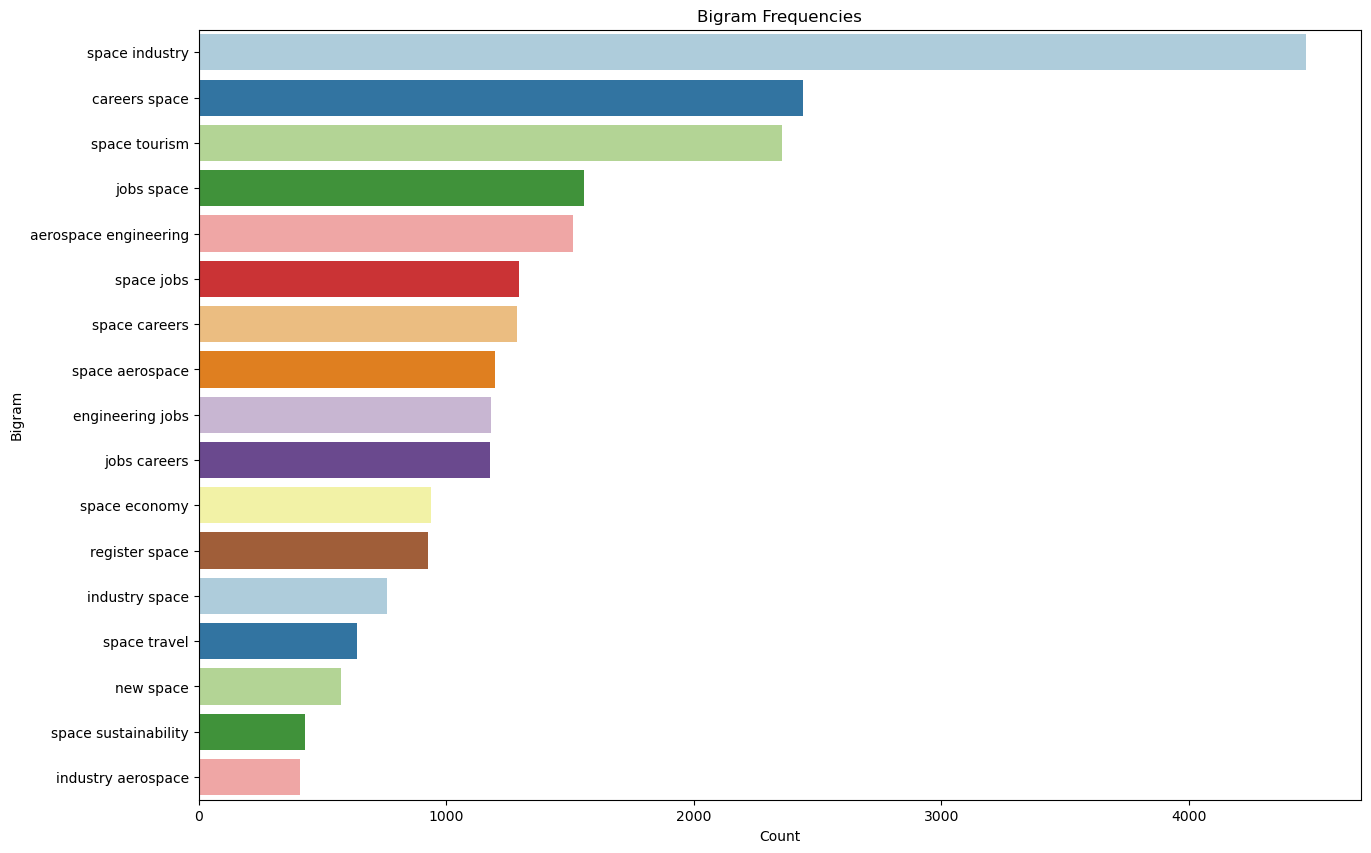

In [222]:
#Creating Bigrams
def get_bigrams(tweets, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(tweets)
    bag_of_words = vec.transform(tweets)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

bi_common_words = get_bigrams(processed_tweets['tweet'], 20)


exclude_bigram = [('space space'), ('tel lite'), ('tel lites')]
filtered_common_words = [item for item in bi_common_words if item[0] not in exclude_bigram]

bigram_df = pd.DataFrame(filtered_common_words, columns=['bigram', 'count'])
bigrams = bigram_df.groupby('bigram').sum()['count'].sort_values(ascending=False)

bigrams = bigrams.reset_index()

plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='bigram', data=bigrams, palette='Paired')
plt.title('Bigram Frequencies')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()


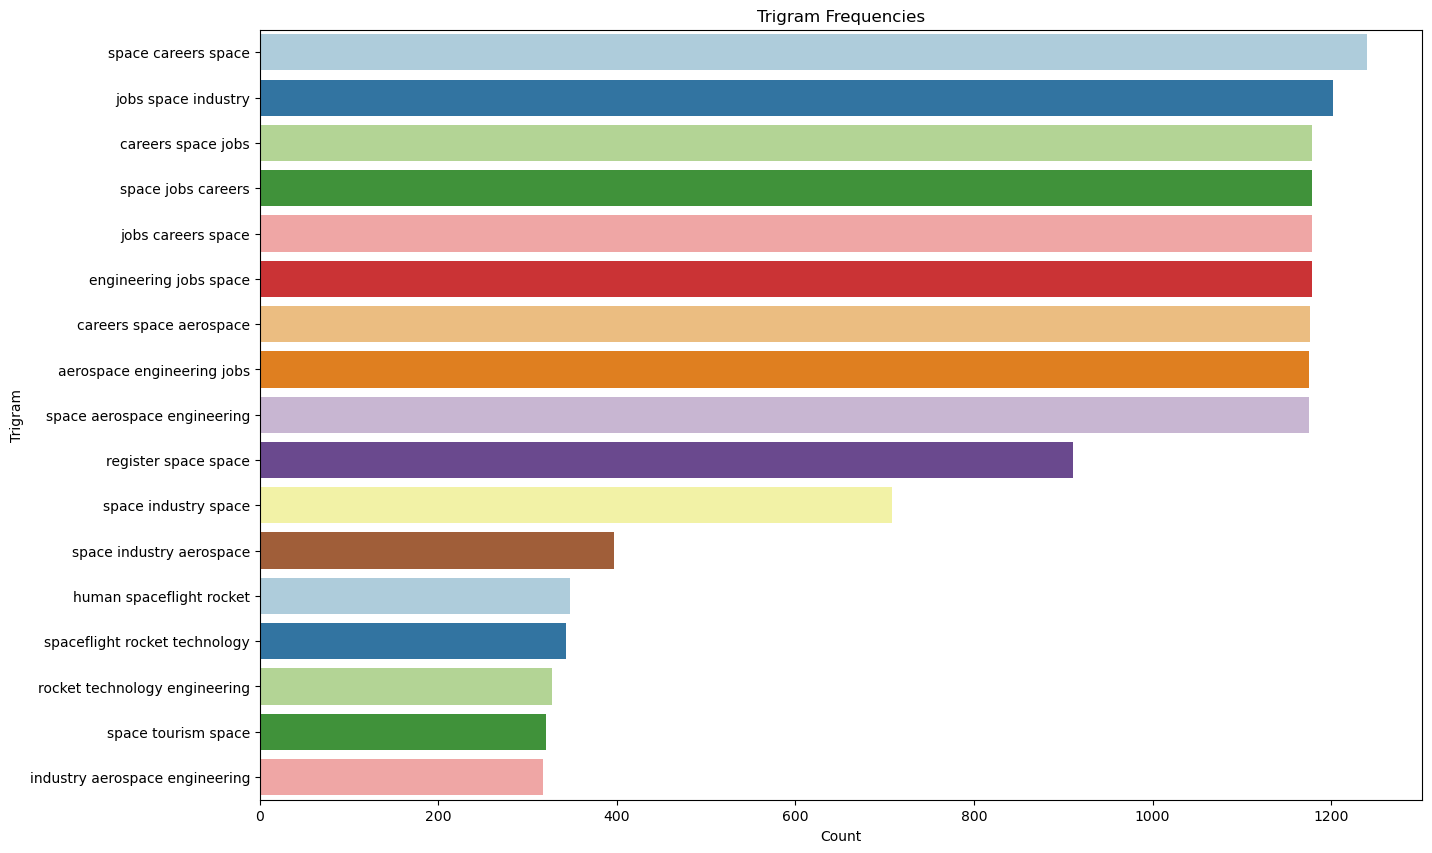

In [224]:
def get_trigrams(tweets, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(tweets)
    bag_of_words = vec.transform(tweets)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

tri_common_words = get_trigrams(processed_tweets['tweet'], 20)


exclude_trigram = [('space space careers'), ('space space industry'), ('vel op ment')]
filtered_common_words = [item for item in tri_common_words if item[0] not in exclude_trigram]

trigram_df = pd.DataFrame(filtered_common_words, columns=['trigram', 'count'])
trigrams = trigram_df.groupby('trigram').sum()['count'].sort_values(ascending=False)


trigrams = trigrams.reset_index()

plt.figure(figsize=(15, 10))
sns.barplot(x='count', y='trigram', data=trigrams, palette='Paired')
plt.title('Trigram Frequencies')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()


/Users/andrelawrence/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



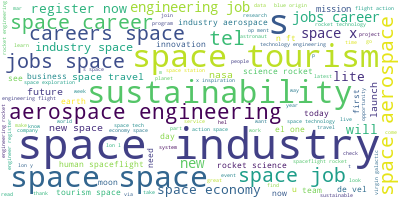

In [200]:
# Joining the processed tweets together
long_string = ','.join(list(processed_tweets['tweet'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualising the word cloud
wordcloud.to_image()

In [201]:
#Tokenising the tweets

def tokenise_tweets(tweet):
    return simple_preprocess(tweet) 

lda_tweets = processed_tweets['tweet'].apply(tokenise_tweets)

print(lda_tweets[:30])

0     [we, could, not, be, more, proud, to, be, part...
1     [exciting, meeting, coming, up, soon, the, wor...
2     [we, could, not, be, more, proud, to, be, part...
3     [were, announcing, new, partnership, with, tha...
4     [north, star, is, proud, to, announce, strateg...
5     [were, announcing, new, partnership, with, tha...
6     [on, this, day, last, year, us, space, com, si...
7     [on, this, day, last, year, us, space, com, si...
8     [incredible, everything, out, of, park, space,...
9     [super, excited, and, pleased, to, have, been,...
10    [super, excited, and, pleased, to, have, been,...
11    [amid, rising, awareness, of, cruel, on, ty, f...
12    [after, some, time, away, returns, next, month...
13    [for, an, undisclosed, sum, acquired, numeric,...
14    [in, the, samsung, global, goals, app, launche...
15    [connie, mccrea, th, operations, manager, of, ...
16    [connie, mccrea, th, operations, manager, of, ...
17    [it, is, sustainability, week, for, us, at

In [202]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['nd', 'gala', 'tic', 'nd', 'com', 'con', 'th', 'el', 'lon','ler', 'pedia', 'crypto', 'tel', 'art', 'artist', 'streamer'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tweet):
    return [word for word in tweet if word not in stop_words]


# Build the bigram and trigram models
def lda_bigram(lda_tweets, min_count=5, threshold=5):
    bigram_model = Phrases(lda_tweets, min_count=min_count, threshold=threshold) # higher threshold fewer phrases.
    lda_bigrams = gensim.models.phrases.Phraser(bigram_model)
    return lda_bigrams

def lda_trigram(tweets, bigram_phraser, min_count=5, threshold=5):
    trigram_model = Phrases(bigram_phraser[lda_tweets], min_count=min_count, threshold=threshold)
    lda_trigrams = gensim.models.phrases.Phraser(trigram_model)
    return lda_trigrams

#Lemmatise

def lemmatise(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lemmatised_tweets = []
    for tweet in tweets:
        doc = nlp(" ".join(tweet))
        lemmatised_tweet = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        lemmatised_tweets.append(lemmatised_tweet)
    return lemmatised_tweets


In [203]:


# Remove Stop Words
lda_tweets_no_stop = lda_tweets.apply(remove_stopwords)

# Form Bigrams
lda_bigrams = lda_bigram(lda_tweets_no_stop)

lda_tweets_bigrams = [lda_bigrams[tweet] for tweet in lda_tweets_no_stop]

#Form Trigrams
lda_trigrams = lda_trigram(lda_tweets_bigrams, lda_bigrams)
lda_tweets_trigrams = [lda_trigrams[bigrammed_tweet] for bigrammed_tweet in lda_tweets_bigrams]

# Initialize spacy 'en' model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatisation keeping only noun, adj, vb, adv
lda_tweets = lemmatise(lda_tweets_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



print(lda_tweets[:30])

[['proud', 'part', 'phase', 'clear', 'mission', 'commission', 'working_toward'], ['exciting', 'meeting', 'world', 'space', 'week', 'arrive', 'raise_awareness', 'importance', 'sustainability', 'space'], ['proud', 'part', 'phase', 'clear', 'mission', 'commission', 'working_toward', 'promote', 'mission', 'hel_ping', 'raise_awareness', 'importance', 'space', 'sustainability'], ['announce', 'new', 'partnership', 'harness', 'benefit', 'combine', 'precise', 'space'], ['proud', 'announce', 'strategic', 'partnership', 'combine', 'space', 'situational_awareness', 'capability', 'orbit_service', 'expertise', 'significant', 'step', 'next', 'generational', 'solution'], ['announce', 'new', 'partnership', 'harness', 'benefit', 'combine', 'precise', 'space', 'situational_awareness', 'service', 'support', 'loni_able', 'orbit_service', 'leo', 'first', 'oo', 'space', 'sustainability'], ['day', 'last_year', 'space', 'sign', 'space', 'situational_awareness', 'memorandum', 'understand'], ['day', 'last_year',

In [204]:
# Create Dictionary
id2word = corpora.Dictionary(lda_tweets)

# Create Corpus
texts = lda_tweets

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:100])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1)], [(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (9, 1), (11, 1), (12, 1), (13, 1), (16, 1), (17, 1)], [(12, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(5, 1), (12, 1), (18, 1), (20, 1), (23, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(12, 2), (13, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (29, 1), (31, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(12, 2), (31, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)], [(12, 3), (17, 1), (31, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(12, 1), (13, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)],

In [205]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [206]:
#Viewing results
pprint(lda_model.print_topics())
twitter_lda = lda_model[corpus]

[(0,
  '0.356*"space" + 0.094*"industry" + 0.038*"job" + 0.032*"career" + '
  '0.027*"aerospace_engineering" + 0.027*"jobs_career" + 0.017*"register" + '
  '0.013*"economy" + 0.012*"technology" + 0.006*"engineer"'),
 (1,
  '0.030*"sustainability" + 0.026*"people" + 0.018*"work" + 0.017*"learn" + '
  '0.015*"build" + 0.013*"trip" + 0.013*"high" + 0.012*"give" + '
  '0.011*"support" + 0.010*"product"'),
 (2,
  '0.027*"sustainability" + 0.019*"food" + 0.016*"climate" + 0.016*"even" + '
  '0.015*"safe" + 0.014*"water" + 0.014*"keep" + 0.013*"moon" + 0.013*"green" '
  '+ 0.012*"home"'),
 (3,
  '0.032*"sustainability" + 0.017*"space" + 0.010*"service" + '
  '0.010*"experience" + 0.009*"important" + 0.009*"look" + 0.009*"use" + '
  '0.008*"good" + 0.008*"market" + 0.008*"podcast"'),
 (4,
  '0.193*"space" + 0.096*"tourism" + 0.035*"travel" + 0.010*"sustainability" + '
  '0.010*"virgin_galactic" + 0.008*"blue_origin" + 0.007*"year" + '
  '0.006*"world" + 0.006*"future" + 0.006*"earth"'),
 (5,
 

In [207]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lda_tweets, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3016273158764906


In [208]:
# supporting coherence function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lda_tweets, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [201]:
#Hyper-parameter grid function

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation sets
    for i in range(len(corpus_sets)):
        # iterate through topics
        for k in topics_range:
            # iterate through alpha 
            for a in alpha:
                # iterare through beta 
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [3:27:22<00:00, 23.04s/it]


In [209]:
#using the optimal model

num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha= 'symmetric',
                                           eta=0.91)

In [277]:
#Viewing results
pprint(lda_model.print_topics())
twittero_lda = lda_model[corpus]

[(0,
  '0.265*"space" + 0.075*"industry" + 0.027*"job" + 0.024*"career" + '
  '0.020*"aerospace_engineering" + 0.019*"jobs_career" + 0.015*"economy" + '
  '0.013*"register" + 0.010*"technology" + 0.008*"new"'),
 (1,
  '0.032*"launch" + 0.016*"rocket" + 0.005*"lite" + 0.005*"test" + '
  '0.004*"weather" + 0.003*"first" + 0.003*"spa" + 0.003*"news" + '
  '0.003*"artemis" + 0.003*"sls"'),
 (2,
  '0.006*"lunar" + 0.005*"contract" + 0.004*"sale" + 0.003*"agreement" + '
  '0.003*"sign" + 0.002*"architecture" + 0.002*"ape" + 0.002*"design" + '
  '0.002*"architect" + 0.002*"award"'),
 (3,
  '0.022*"track" + 0.021*"musk" + 0.020*"tourism_inspiration" + '
  '0.018*"landing_inspiration" + 0.012*"inspiration_tracke" + 0.010*"live" + '
  '0.009*"map_inspiration" + 0.009*"watch_live" + 0.009*"reentry_inspiration" '
  '+ 0.008*"map_reentry"'),
 (4,
  '0.149*"space" + 0.067*"tourism" + 0.023*"travel" + 0.007*"flight" + '
  '0.007*"virgin_galactic" + 0.006*"blue_origin" + 0.006*"station" + '
  '0.006*"

In [210]:
#Determining the number of topics per tweet
def topics_per_tweet(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        try:
            topic_percs = model[corp]
            dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
            dominant_topics.append((i, dominant_topic))
            topic_percentages.append(topic_percs)
        except ValueError:
            print(f"Error processing document index {i}")
    return(dominant_topics, topic_percentages)


dominant_topics, topic_percentages = topics_per_tweet(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Tweet_Id', 'Dominant_Topic'])
dominant_topic_in_each_tweet = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_tweet = dominant_topic_in_each_tweet.to_frame(name='count').reset_index()



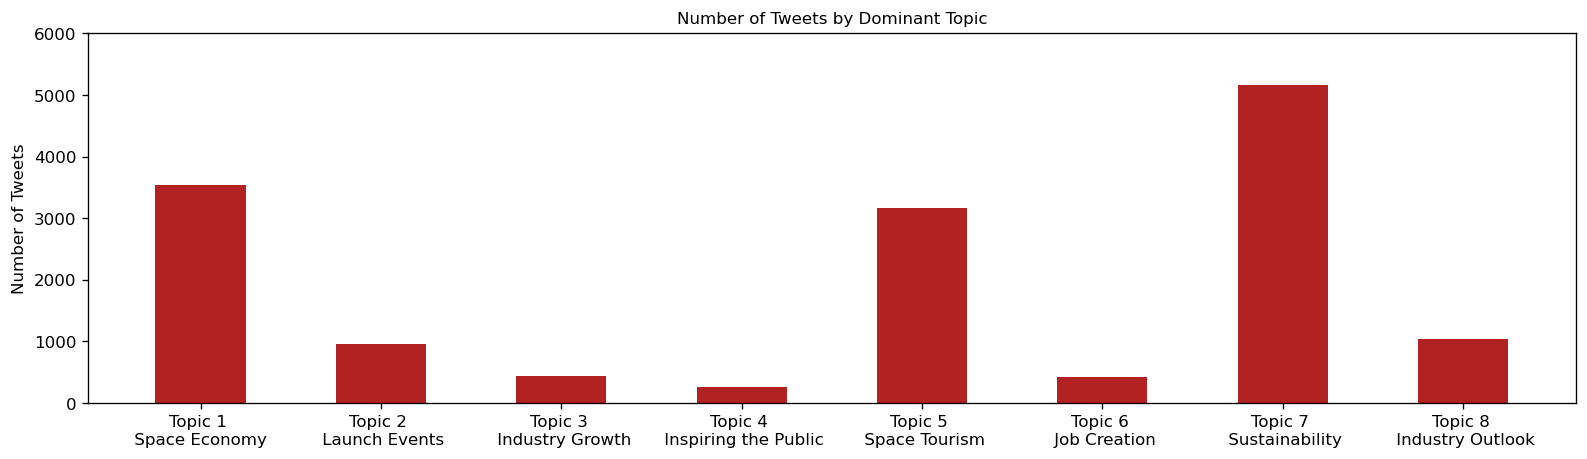

In [338]:
# Plotting results
fig, ax1 = plt.subplots(figsize=(16, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_tweet, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_tweet.Dominant_Topic.unique().__len__()))

ax1.set_xticklabels(['Topic 1 \n Space Economy ', 'Topic 2 \n Launch Events', 'Topic 3 \n Industry Growth', 'Topic 4 \n Inspiring the Public', 'Topic 5 \n Space Tourism', 'Topic 6 \n Job Creation', 'Topic 7 \n Sustainability', 'Topic 8 \n Industry Outlook'])

ax1.set_title('Number of Tweets by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Tweets')
ax1.set_ylim(0, 6000)

plt.show()

In [344]:
#Generating T-SNE model
from bokeh.models import Legend
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for _, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)
legend_items = []
topics = ['Topic 1: Space Economy ', 'Topic 2: Launch Events', 'Topic 3: Industry Growth', 'Topic 4: Inspiring the Public', 'Topic 5: Space Tourism', 'Topic 6: Job Creation', 'Topic 7: Sustainability', 'Topic 8: Industry Outlook']
    # Append to legend items

# Loop through each unique topic number to plot and label in legend
for i in np.unique(topic_num):
    # Indices for each topic
    topic_indices = np.where(topic_num == i)[0]
    
    # Scatter points for each topic
    scatter = plot.scatter(x=tsne_lda[topic_indices, 0], 
                           y=tsne_lda[topic_indices, 1], 
                           color=mycolors[i])

    # Append to legend items
    legend_items.append((topics[i], [scatter]))


# Configure legend properties
legend = Legend(items=legend_items, location="top_left")
plot.add_layout(legend, 'right')
plot.legend.label_text_font_size = '10pt'
plot.legend.background_fill_alpha = 0.6

show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14892 samples in 0.007s...
[t-SNE] Computed neighbors for 14892 samples in 0.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14892
[t-SNE] Computed conditional probabilities for sample 2000 / 14892
[t-SNE] Computed conditional probabilities for sample 3000 / 14892
[t-SNE] Computed conditional probabilities for sample 4000 / 14892
[t-SNE] Computed conditional probabilities for sample 5000 / 14892
[t-SNE] Computed conditional probabilities for sample 6000 / 14892
[t-SNE] Computed conditional probabilities for sample 7000 / 14892
[t-SNE] Computed conditional probabilities for sample 8000 / 14892
[t-SNE] Computed conditional probabilities for sample 9000 / 14892
[t-SNE] Computed conditional probabilities for sample 10000 / 14892
[t-SNE] Computed conditional probabilities for sample 11000 / 14892
[t-SNE] Computed conditional probabilities for sample 12000 / 14892
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [255]:
#Using Vader

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['vader_polarity'] = processed_tweetsVADER['tweet'].map(
    lambda tweet: sid.polarity_scores(tweet)['compound'])                 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrelawrence/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [257]:
#Using Text Blob

df['blob_polarity'] = processed_tweets['tweet'].map(
    lambda tweet: TextBlob(tweet).sentiment.polarity)

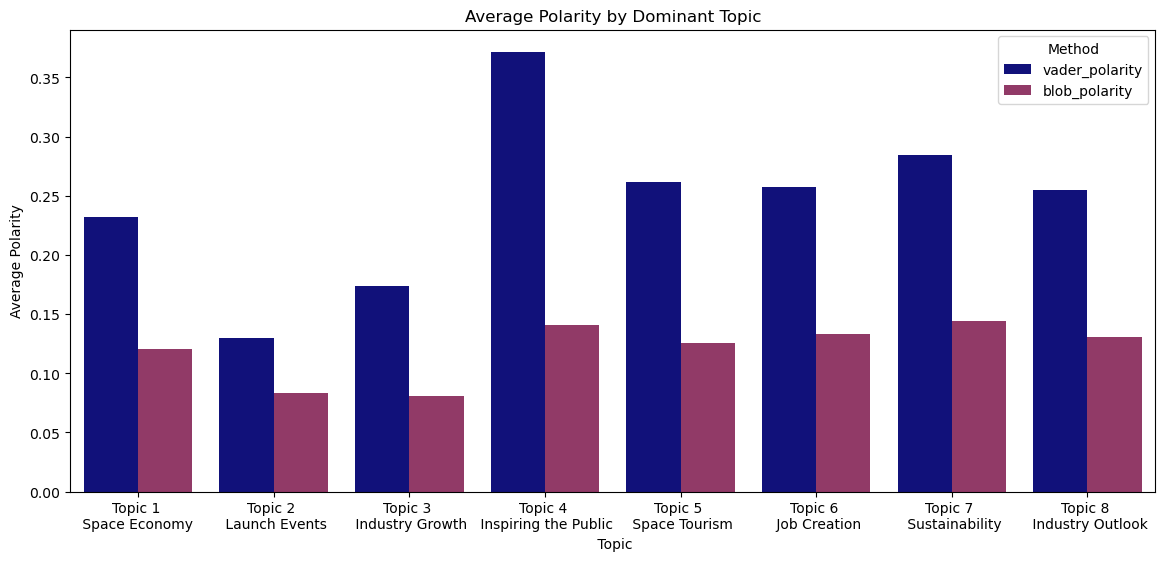

In [345]:
grouped_df = df.groupby('Dominant_Topic').agg({
    'vader_polarity': 'mean',
    'blob_polarity': 'mean'
}).reset_index()

# Melt the DataFrame to make it suitable for seaborn plotting
melted_df = pd.melt(grouped_df, id_vars=['Dominant_Topic'], value_vars=['vader_polarity', 'blob_polarity'],
                    var_name='Method', value_name='Average_Polarity')

# Plot using seaborn
plt.figure(figsize=(14, 6))
ax = sns.barplot(x='Dominant_Topic', y='Average_Polarity', hue='Method', data=melted_df, palette=['#00008b', '#9F2B68'])
labels = ['Topic 1 \n Space Economy ', 'Topic 2 \n Launch Events', 'Topic 3 \n Industry Growth', 'Topic 4 \n Inspiring the Public', 'Topic 5 \n Space Tourism', 'Topic 6 \n Job Creation', 'Topic 7 \n Sustainability', 'Topic 8 \n Industry Outlook']
ax.set_xticklabels(labels)
plt.xlabel(' Topic')
plt.ylabel('Average Polarity')
plt.title('Average Polarity by Dominant Topic')
plt.legend(title='Method')
plt.show()

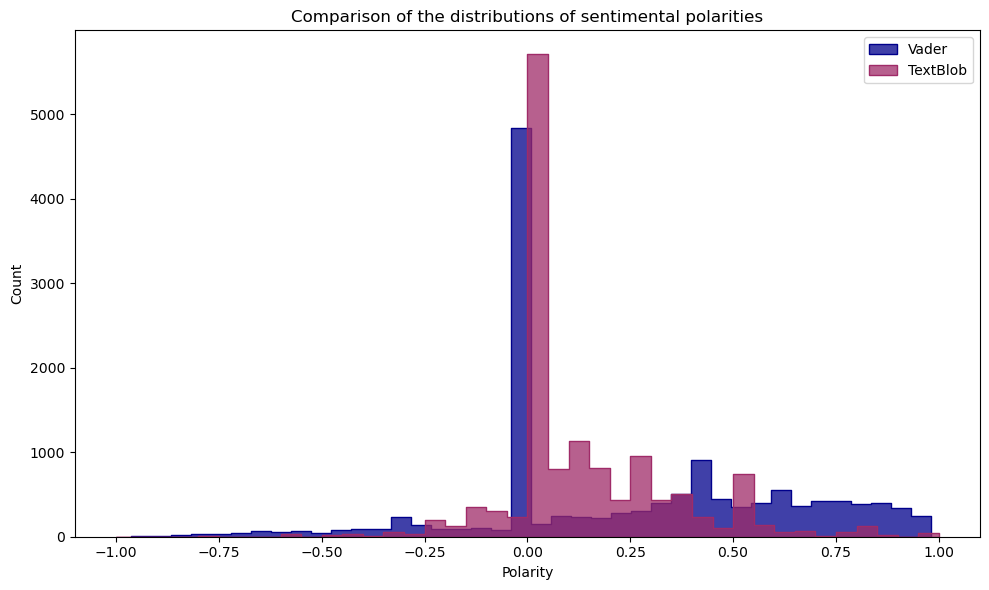

In [258]:
# Extract the data
polarity_df = df[['vader_polarity', 'blob_polarity']]
polarity_df = polarity_df.rename(columns={'vader_polarity': 'Vader',
                                          'blob_polarity': 'TextBlob'})

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot the histograms
colors = ['#00008b', '#9F2B68']
for column, color in zip(polarity_df.columns, colors):
    sns.histplot(polarity_df[column], bins=40, color=color, label=column, kde=False, element="step", common_norm=False)

# Set title and labels
plt.title('Comparison of the distributions of sentimental polarities')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [262]:
#Finding sentiment counts

def classify_sentiment(score):
    if score > 0.25:
        return 'Highly Postive'
    if score > 0.05:
        return 'positive'
    elif score < -0.25:
        return 'Highly Negative'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the classify_sentiment function to each polarity column
polarity_df['Vader_sentiment'] = polarity_df['Vader'].apply(classify_sentiment)
polarity_df['TextBlob_sentiment'] = polarity_df['TextBlob'].apply(classify_sentiment)

# Get the counts of sentiments for each model
vader_counts = polarity_df['Vader_sentiment'].value_counts()
textblob_counts = polarity_df['TextBlob_sentiment'].value_counts()

print("Vader Sentiment Counts:\n", vader_counts)
print("\nTextBlob Sentiment Counts:\n", textblob_counts)


Vader Sentiment Counts:
 Highly Postive     6438
neutral            6159
positive           1026
Highly Negative     971
negative            389
Name: Vader_sentiment, dtype: int64

TextBlob Sentiment Counts:
 neutral            7248
positive           3637
Highly Postive     3029
negative            871
Highly Negative     198
Name: TextBlob_sentiment, dtype: int64
